## Importing Libraries

In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np

## Creating data generator

In [0]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()
x_train=x_train.reshape(60000, 28, 28, 1).astype('float32')/255.0
x_test=x_test.reshape(10000, 28, 28, 1).astype('float32')/255.0
y_train=y_train.reshape(60000, ).astype('int64')
y_test=y_test.reshape(10000, ).astype('int64')

### Writting tf record

In [0]:
def wrap_int64(val):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[val]))

def wrap_bytes(val):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[val]))

def convert_tfrecord(images,labels,out_path):
  with tf.io.TFRecordWriter(out_path) as writer:
    for image,label in zip(images,labels):
      img=image.tobytes()  
      mnist={
          'image':wrap_bytes(img),
          'label':wrap_int64(int(label))
      }
      feature=tf.train.Features(feature=mnist)
      example=tf.train.Example(features=feature)
      serialized=example.SerializeToString()
      writer.write(serialized)

out_path='/content/train.tfrecords'
convert_tfrecord(x_train,y_train,out_path)
test_out_path='/content/test.tfrecords'
convert_tfrecord(x_test,y_test,test_out_path)

### Parsing TFRecords


In [0]:
def convert_back(serialized):  
  feature={
      'image':tf.io.FixedLenFeature([],tf.string),
      'label':tf.io.FixedLenFeature([],tf.int64)
  }
  parsed_example = tf.io.parse_single_example(serialized=serialized,
                                            features=feature)
  image_raw = tf.io.decode_raw(parsed_example['image'],tf.int32)
  img=tf.reshape(image_raw, shape=[28, 28, 1])
  label=tf.cast(parsed_example['label'],tf.uint32)
  return img, label

### Data Generator

In [0]:
batch_size=64
epochs=5
def data_gen(files):
  dataset=tf.data.TFRecordDataset(filenames=files)
  dataset = dataset.map(convert_back)
  dataset = dataset.shuffle(10000)
  dataset = dataset.batch(batch_size)
  dataset = dataset.repeat(epochs)
  return dataset

files='/content/test.tfrecords'
test_files='/content/train.tfrecords'
train_dataset=data_gen(files)
test_dataset=data_gen(test_files)

## Visualizing Input Images


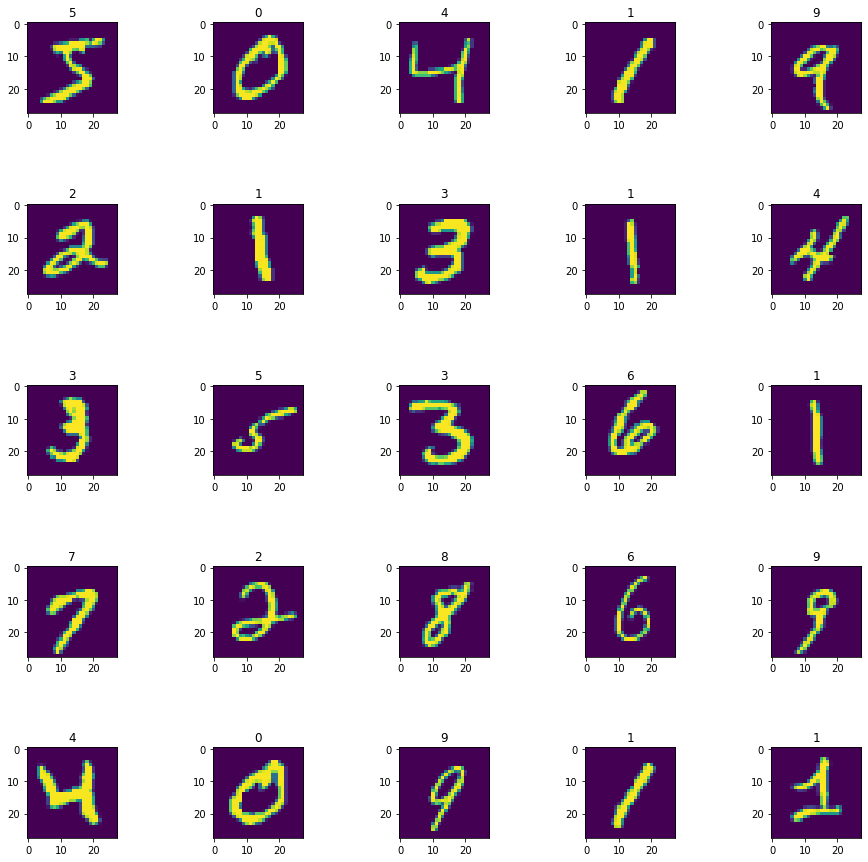

In [7]:
plt.figure(figsize=(15,15))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(np.reshape(x_train[i], (28, 28)))
  plt.title(y_train[i])
  plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

## Model

In [8]:
def build_model():
  model_input=tf.keras.layers.Input(shape=(28,28,1))
  layer=tf.keras.layers.Conv2D(16,3,activation='relu',\
                              kernel_initializer='uniform')(model_input)
  layer=tf.keras.layers.MaxPooling2D(2,1,'same')(layer)

  layer=tf.keras.layers.Conv2D(32,3,activation='relu',\
                              kernel_initializer='uniform')(layer)
  layer=tf.keras.layers.MaxPooling2D(2,1,'same')(layer)

  layer=tf.keras.layers.Conv2D(64,3,activation='relu',\
                              kernel_initializer='uniform')(layer)                             
  layer=tf.keras.layers.MaxPooling2D(2,1,'same')(layer)

  layer=tf.keras.layers.Flatten()(layer)
  model_output=tf.keras.layers.Dense(10,activation='softmax')(layer)
  model=tf.keras.models.Model(model_input,model_output)
  model.summary()
  return model
model=build_model()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0     

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),\
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
callback=[(tf.keras.callbacks.ModelCheckpoint(filepath='/content/mnist_model.h5',
                                            patience=0, verbose=0))]
model.fit(train_dataset,epochs=5,callbacks=callback,batch_size=batch_size)

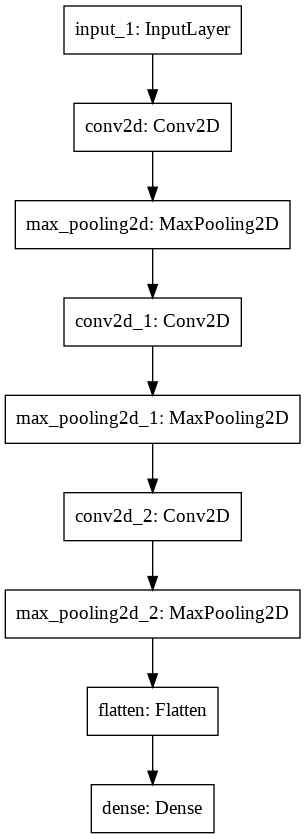

In [9]:
tf.keras.utils.plot_model(model, 'mnist_model.png')

## Prediction On Test Data 


In [0]:
y_pred=model.predict(test_dataset)
y_pred=np.argmax(y_pred,axis=1)

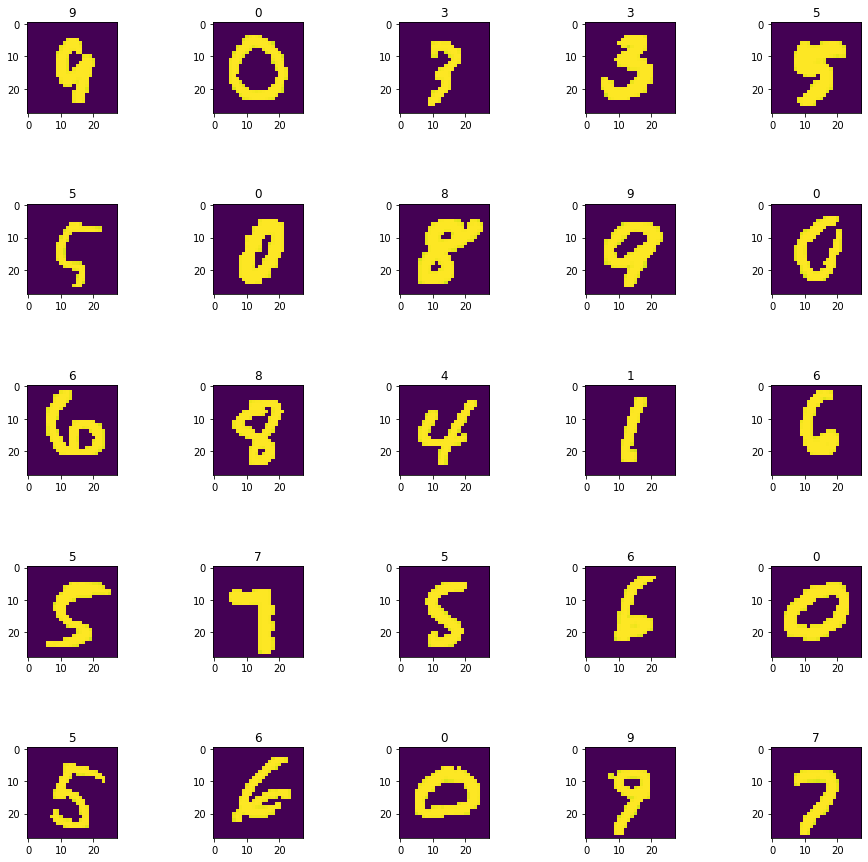

In [13]:
plt.figure(figsize=(15,15))
for i in range(25):
  for val in test_dataset.take(1):
    plt.subplot(5,5,i+1)
    plt.imshow(tf.reshape(val[0][i],[28,28]))
    plt.title(y_pred[i])
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()